In [1]:
import sys
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor,
                              IsolationForest)
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import (LinearRegression, HuberRegressor, PassiveAggressiveRegressor, TheilSenRegressor,
                                  RANSACRegressor, Lasso)
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeRegressor


In [2]:
# Open csv files and pull data
df_train_temp = pd.read_csv('train.csv')
df_test_temp  = pd.read_csv('test.csv')


In [3]:
# Convert categorical columns to multiple binary columns of type int
df_train = pd.get_dummies(df_train_temp, drop_first = True)
df_test  = pd.get_dummies(df_test_temp, drop_first = True)

# Replace all nulls with 0's
df_train.fillna(0, inplace = True)
df_test.fillna(0, inplace = True)


In [4]:
# Add null columns for values that don't show up in test that show up in training, except SalePrice
for i in list(np.setdiff1d(list(df_train.columns.values), list(df_test.columns.values))):
    df_test[str(i)] = 0
    
# Move the target variable, SalePrice to the last column
df_train['SalePriceLastColumn'] = df_train['SalePrice']
df_train.drop('SalePrice', axis = 1, inplace = True)
df_train.rename(columns = {'SalePriceLastColumn': 'SalePrice'}, inplace = True)

# Reorder the columns to match the training set
df_test = df_test[df_train.columns.values[:-1]]


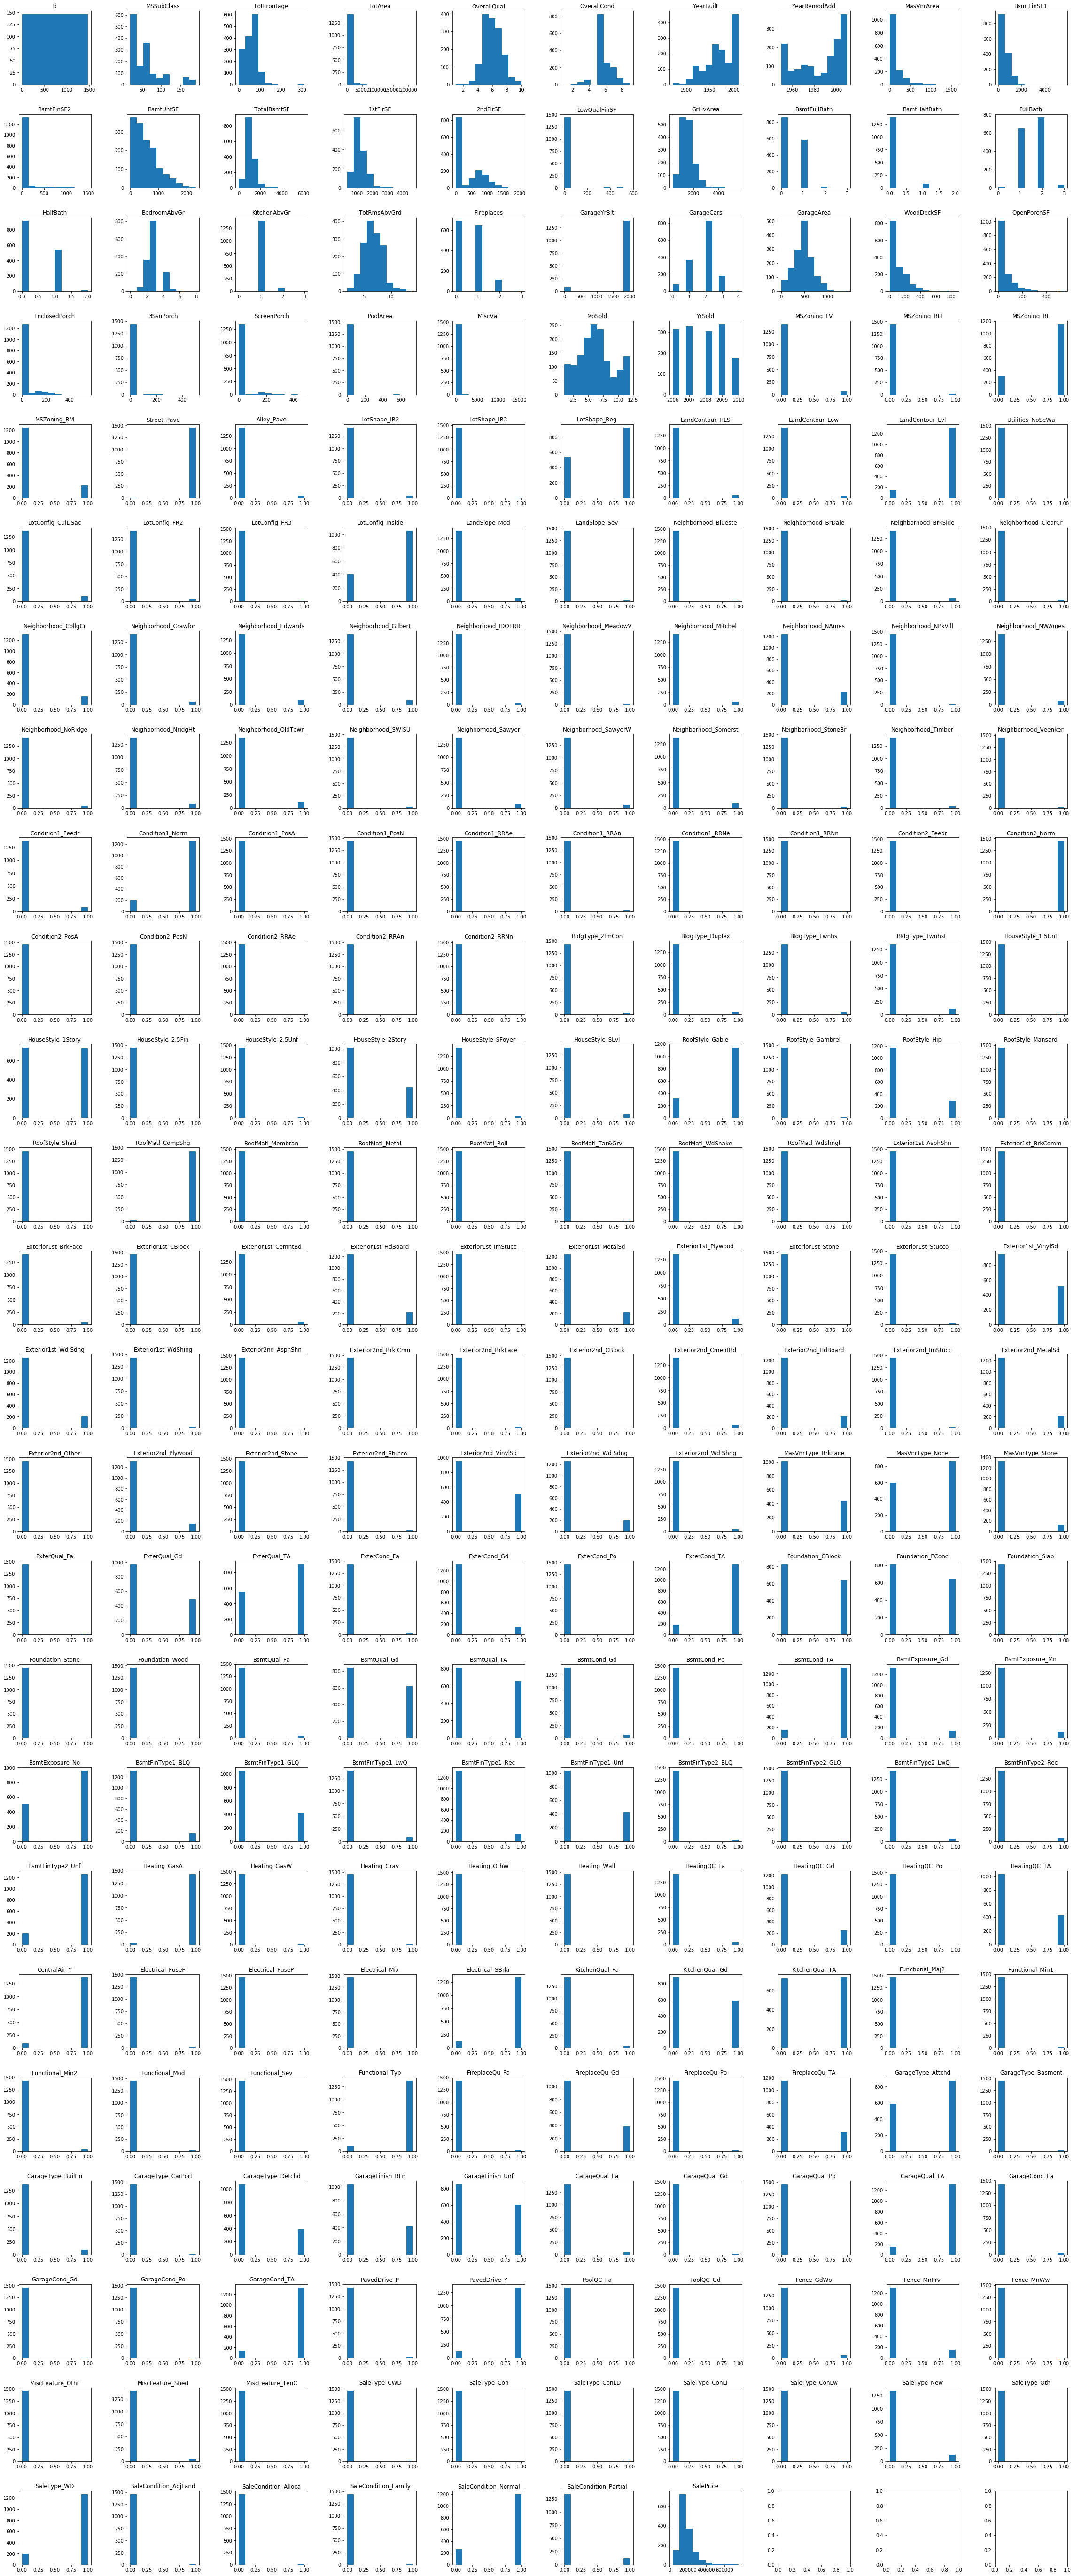

In [5]:
nrow = 25
ncol = 10

plt.clf()

fig, ax = plt.subplots(nrow, ncol, figsize = (40, 100))

for i in range(nrow):
    for j in range(ncol):
        ax[i, j].hist(df_train.iloc[:, ncol * i + j], orientation = 'vertical', cumulative = False)
        ax[i, j].set_title(df_train.iloc[:, ncol * i + j].name)
        
        plt.subplots_adjust(wspace = .5, hspace = .4)
        
        if ncol * i + j >= df_train.shape[1] - 1:
            break
            
    if ncol * i + j >= df_train.shape[1] - 1:
        break
        
plt.show()


In [7]:
# Split the dataframe into the features and target variable
xtrainlr, xdevlr, ytrainlr, ydevlr = train_test_split(df_train.drop(['Id','SalePrice'], axis = 1), df_train['SalePrice'],
                                                      test_size = 0.1, random_state = 0)

# Linear Regression Model
lr       = LinearRegression().fit(xtrainlr, ytrainlr)
lr_preds = lr.predict(xdevlr)

# It's feasible to have a negative prediction for the SalePrice, but we cannot take the log of a negative value
lr_preds[lr_preds < 0] = 1

print 'The linear model accounts for {:.3} of the variance in the data'.format(r2_score(ydevlr, lr_preds) * 100)
print 'The linear mean squared error is {:.3}'.format(mean_squared_error(np.log(ydevlr), np.log(lr_preds)))


The linear model accounts for 82.7 of the variance in the data
The linear mean squared error is 0.03


In [6]:
c = ['Coefficient Name', 'Coefficient Val']
top10 = pd.DataFrame(zip(df_train.drop(['Id','SalePrice'], axis = 1).columns[np.argsort(np.abs(lr.coef_))[-10:]], 
                         lr.coef_[np.argsort(np.abs(lr.coef_))[-10:]]), columns = c)

bottom10 = pd.DataFrame(zip(df_train.drop(['Id','SalePrice'], axis = 1).columns[np.argsort(np.abs(lr.coef_))[:10]], 
                            lr.coef_[np.argsort(np.abs(lr.coef_))[:10]]), columns = c)

print "Five Most Influential Coefficients"
print top10.reindex(top10['Coefficient Val'].abs().sort_values(ascending = False).index)
print "\r\nFive Least Influential Coefficients"
print bottom10.reindex(bottom10['Coefficient Val'].abs().sort_values().index)

Five Most Influential Coefficients
  Coefficient Name  Coefficient Val
9  Condition2_PosN   -446500.301280
8  Condition2_RRAe   -129941.834627
7        PoolQC_Gd    128357.596553
6    GarageQual_Po   -116656.588050
5    GarageQual_Fa   -113140.791977
4    GarageQual_TA   -110002.845227
3    GarageQual_Gd   -107480.271310
2    GarageCond_TA    106060.859883
1    GarageCond_Fa    103344.656730
0        PoolQC_Fa    101303.616078

Five Least Influential Coefficients
   Coefficient Name  Coefficient Val
0  MiscFeature_TenC     2.910383e-11
1    Functional_Sev    -4.365575e-11
2   Condition2_RRNn     2.892193e-10
3   Condition2_RRAn     4.783942e-10
4           MiscVal     5.823847e-01
5           LotArea     7.799185e-01
6         BsmtUnfSF    -1.240089e+00
7        BsmtFinSF2     7.497218e+00
8          1stFlrSF     8.547237e+00
9      LowQualFinSF     9.378269e+00


Mention how the linear model performance was pretty terrible, and how it allows for the possibility of negative price predictions (making it impossible to take the log for the model performance).

According to the linear regression model, various quality and condition measurements are the most influencial feature affecting a home's sale price, this seems somewhat intuitive yet the accuracy of this model is too low to be useful. Let's see how this can be improved.

## Principal Component Analysis


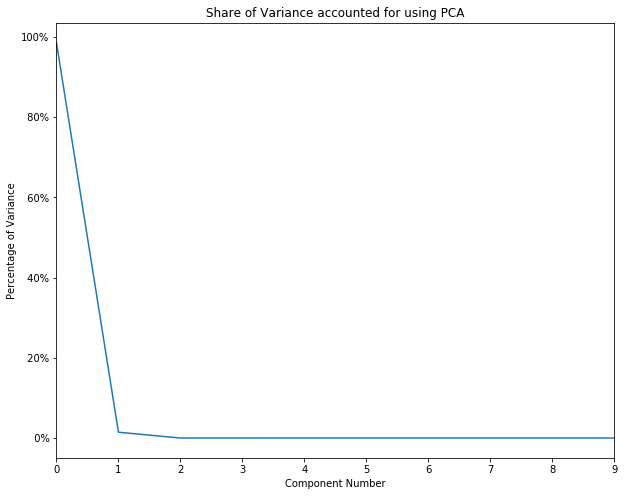

In [7]:
# Fit the training data using PCA
pca_model = PCA()
pca_model.fit(df_train)

# Plot the share of variance for the first 10 components
ax = pd.DataFrame(pca_model.explained_variance_ratio_[:10]).plot(
    title = "Share of Variance accounted for using PCA",
    legend = False,
    figsize = (10, 8))

# Set Axis labels and tick marks
ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in ax.get_yticks()])
ax.set_xlabel("Component Number")
ax.set_ylabel("Percentage of Variance")

plt.show()


Only 1 principal component accounts for ≈98% of the total variance. This indicates that the data is linear, which is somewhat surprising given the inaccuracy of the linear model, yet not unexpected due to the fact that our explanatory variables, the majority of which are categorical, are not likely strongly correlated with one another.

In [8]:
# Split the dataframe into the features and target variable
xtraindt, xdevdt, ytraindt, ydevdt = train_test_split(df_train.drop(['Id','SalePrice'], axis = 1), df_train['SalePrice'],
                                                      test_size = 0.2, random_state = 0)

# Decision Tree Model
dt_preds = cross_val_predict(DecisionTreeRegressor(), xtraindt, ytraindt, cv = 3)

print mean_squared_error(np.log(ytraindt), np.log(dt_preds))


0.0468265517482


In [9]:
# Data and training labels
# Note: Using the full training set since GridSearchCV performs
# train / test splits internally
X = df_train.drop(['Id','SalePrice'], axis = 1)
y = df_train['SalePrice']

def test_estimators(est_dicts):
    # Runs grid search on each estimator and records the best score
    # and standard deviation
    
    best_est_res = {} # Stores estimator performance data
    for est_dict in est_dicts:
        print "Running grid search on {} estimator".format(est_dict['name'])
        grid = GridSearchCV(est_dict['callable'], est_dict['params'], scoring = 'neg_mean_squared_log_error', n_jobs = -1, 
                            verbose = True)
        grid.fit(X, y)
        
        score, std_dev, est_call = (grid.best_score_, np.mean(grid.cv_results_['neg_mean_squared_log_error']), 
                                    grid.best_estimator_)
        best_est_res[est_dict['name']] = [score, std_dev, est_call]
    
    return best_est_res


In [ ]:
Huber_params = {'epsilon': [1.1, 1.35, 2.0], 'max_iter': [100, 300]}
PassiveAggressive_params = { 'C': [0.01, 0.5, 1, 10, 100], 'n_iter': [5, 100], 'verbose': [True]}
RANSAC_params = {'min_samples': [0.1, 0.5, 1.0]}
SVR_params = {'C': [0.01, 0.5, 1, 10, 100]}
Multinomial_params = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Bernoulli_params = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
KNeighbors_params = {'n_neighbors': [1, 10, 100], 'weights': ['uniform', 'distance']}
DecisionTree_params = {'min_samples_leaf': range(50, 80, 2), 'max_features': ['auto', 'sqrt', 0.2]}
Bagging_params = {'n_estimators': [1000, 500, 100], 'max_samples': [1.0, 0.25], 'oob_score': [True, False], 
                  'max_features': [0.65, 0.25]}
RandomForest_params = {'n_estimators': [10, 100, 500], 'min_samples_leaf': range(50, 90, 10), 'oob_score': [True, False], 
                       'max_features': ['auto', 'sqrt', 0.2]}
AdaBoost_params = {'n_estimators': [10, 100, 500]}
IsolationForest_params = {'n_estimators': [100, 500], 'contamination': [0.005, 0.01, 0.1]}

est_dicts = [
    {'name': 'HuberRegressor', 'params': Huber_params, 'callable': HuberRegressor()},
    {'name': 'PassiveAggressiveRegressor', 'params': PassiveAggressive_params, 'callable': PassiveAggressiveRegressor()},
    {'name': 'RANSACRegressor', 'params': RANSAC_params, 'callable': RANSACRegressor()},
    {'name': 'BaggingRegressor', 'params': Bagging_params, 'callable': BaggingRegressor()},
    {'name': 'IsolationForest', 'params': IsolationForest_params, 'callable': IsolationForest()},
    {'name': 'RandomForestRegressor', 'params': RandomForest_params, 'callable': RandomForestRegressor()},
    {'name': 'AdaBoostRegressor', 'params': AdaBoost_params, 'callable': AdaBoostRegressor()},
    {'name': 'SVR', 'params': SVR_params, 'callable': SVR()},
    {'name': 'MultinomialNB', 'params': Multinomial_params, 'callable': MultinomialNB()},
    {'name': 'BernoulliNB', 'params': Bernoulli_params, 'callable': BernoulliNB()},
    {'name': 'KNeighborsRegressor', 'params': KNeighbors_params, 'callable': KNeighborsRegressor()},
    {'name': 'DecisionTreeRegressor', 'params': DecisionTree_params, 'callable': DecisionTreeRegressor()}
]

estimator_results = test_estimators(est_dicts)


Running grid search on HuberRegressor estimator
Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [ ]:
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.pyplot import cm

def plot_best_estimator(estimator_results, custom_axis = None):
    # Plot the best score of each estimator
    fig = plt.figure(figsize = (20, 16))
    ax = fig.add_subplot(111)
    xs = range(len(estimator_results))
    color = iter(cm.rainbow(np.linspace(0, 1, len(xs))))
    labels = estimator_results.keys()

    ax.set_xticks(np.arange(len(xs)))
    ax.set_xticklabels(labels)

    for i, (clf ,result) in enumerate(estimator_results.items()):
        c = next(color)
        ax.errorbar(i, -1.0 * result[0], yerr = result[1], fmt = '--o', color = c, capsize = 5, label = labels[i])
        ax.annotate("{:.2f}\n(+/-{:.2E})".format(-1.0 * result[0], result[1]), (i + 0.05, -1.0 * result[0]))

    plt.title("Estimator RMSE with Average Test Standard Deviation (Lower is better)")
    plt.legend()
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(50)
    
    if custom_axis is not None:
        plt.axis(custom_axis)

plot_best_estimator(estimator_results, [-0.5, len(estimator_results), -0.1, 0.3])

The Random Forest Log of Mean Squared Error is 0.02262


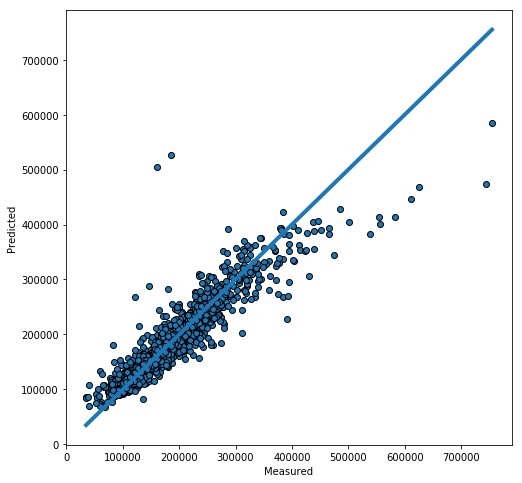

In [40]:
rf_cv_preds = cross_val_predict(RandomForestRegressor(n_estimators = 100, random_state = 0), xtrain, ytrain, cv = 3)

rf_log_mse = mean_squared_error(np.log(ytrain), np.log(rf_cv_preds))
print 'The Random Forest Log of Mean Squared Error is {:.4}'.format(rf_log_mse)

min_axis_val = min(ytrain.min(), rf_cv_preds.min())
max_axis_val = max(ytrain.max(), rf_cv_preds.max())

fig, ax = plt.subplots(figsize = (8, 8))
ax.scatter(ytrain, rf_cv_preds, edgecolors = (0, 0, 0))
ax.plot([min_axis_val, max_axis_val], [min_axis_val, max_axis_val], lw = 4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


In [53]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 0).fit(xtrain, ytrain)

# Add a column to the df_test dataframe with our random forest model predictions
df_test['SalePrice'] = rf.predict(df_test.iloc[:, 1:])


ValueError: Number of features of the model must match the input. Model n_features is 245 and input n_features is 246 

In [ ]:
# Create a csv file of the IDs and predictions
df_test[['Id', 'SalePrice']].round(1).to_csv('PredictingSalePriceRF.csv', index = False)


In [47]:
# Clear the df_test prediction for Bagging Regressor predictions
df_test.drop('SalePrice', axis = 1, inplace = True)


ValueError: labels ['SalePrice'] not contained in axis

The Random Forest Log of Mean Squared Error is 0.02251


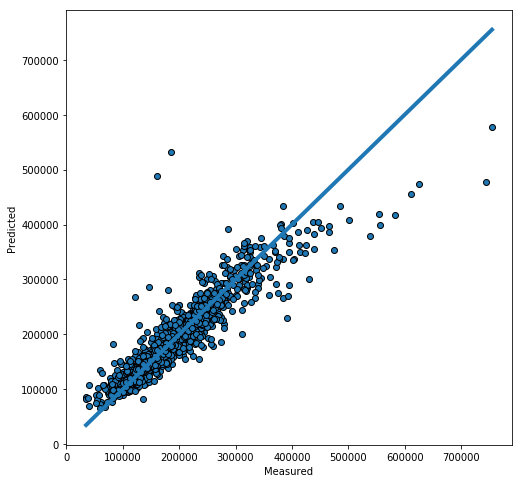

In [48]:
bg_cv_preds = cross_val_predict(BaggingRegressor(n_estimators = 100, random_state = 0), xtrain, ytrain, cv = 3)

bg_log_mse = mean_squared_error(np.log(ytrain), np.log(bg_cv_preds))
print 'The Bagging Regressor Log of Mean Squared Error is {:.4}'.format(bg_log_mse)

min_axis_val = min(ytrain.min(), bg_cv_preds.min())
max_axis_val = max(ytrain.max(), bg_cv_preds.max())

fig, ax = plt.subplots(figsize = (8, 8))
ax.scatter(ytrain, bg_cv_preds, edgecolors = (0, 0, 0))
ax.plot([min_axis_val, max_axis_val], [min_axis_val, max_axis_val], lw = 4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


In [49]:
bg = BaggingRegressor(n_estimators = 100, random_state = 0).fit(xtrain, ytrain)

# Add a column to the df_test dataframe with our random forest model predictions
df_test['SalePrice'] = bg.predict(df_test.iloc[:, 1:])


In [51]:
# Create a csv file of the IDs and predictions
df_test[['Id', 'SalePrice']].round(1).to_csv('PredictingSalePriceBG.csv', index = False)


In [ ]:
# Clear the df_test prediction for future predictions
df_test.drop('SalePrice', axis = 1, inplace = True)


In [15]:
rf_fs = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty = 'l2'))),
  ('regression', RandomForestRegressor(n_estimators = 100))
])
rf_fs.fit(xtrain, ytrain)

# Add a column to the df_test dataframe with our random forest model predictions
df_test['SalePrice'] = rf_fs.predict(df_test.drop('Id', axis = 1))


In [16]:
# Create a csv file of the IDs and predictions
df_test[['Id', 'SalePrice']].round(1).to_csv('PredictingSalePriceRFFS.csv', index = False)
